# Pytorch Paper Replicating - Vision Tranformer (ViT)

### 0. Setup

In [77]:
import torch
import torchinfo
print(torch.__version__)
print(torchinfo.__version__)

2.2.2
1.8.0


In [78]:
import matplotlib.pyplot as plt
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

In [79]:
import requests
from pathlib import Path

# Download Helper functions from Laearn Pytorch repo or from anywhere on the internet
if Path("helper_functions.py").is_file():
    print("File exists skipping download.")
else:
    print("Downloading Helper Functions.py")
    requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(requests.content)

File exists skipping download.


In [80]:
from helper_functions import download_data, set_seeds, plot_loss_curves

In [81]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Get Data
We will be working on the same data we worked earlier on Image classification problem, (DBZ character classification data)

In [82]:
import os

from pathlib import Path

# setup data path
data_path = Path("/Users/venu/Documents/Productivity/Pytorch Tutorials/data")
image_path = Path(data_path / "dragon_ball_images")

In [83]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/train'),
 PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test'))

## 2. Create Datasets and DataLoaders

In [84]:
from going_modular import data_setup

In [85]:
# the ViT used image resolution of 224,224, so we use the same image size
IMG_SIZE = 224

# create transforms pipeline
manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()
                                                        ])

In [86]:
# ViT transformer used batch size of 4096, due to hardware constraints, using smaller batch size of 32
BATCH_SIZE = 32

In [87]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir= train_dir,
                                                                             test_dir = test_dir,
                                                                              batch_size=BATCH_SIZE,
                                                                              num_workers=0,
                                                                             transform = manual_transforms)
train_dataloader, test_dataloader, class_names
len(train_dataloader), len(test_dataloader), class_names

(11, 3, ['goku', 'picolo', 'trunks', 'vegeta'])

### Visualize a single Image

In [101]:
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the above batch
image, label = image_batch[2], label_batch[2]

# print the shape of the single image from the batch
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

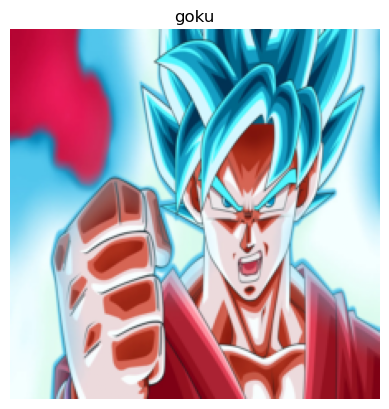

In [102]:
# plot the image and title the label
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) #matlplotlib expects the color channels to be in the last
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview
Breaking down the Machine Learning Model -
* Inputs - What goes into the model. (batches of image tensors)
* Outputs - What comes out of the layers/blocks/model - (labels of the image classification)
* Layers - Takes an Input and manipulates with the help of some function.
* Blocks - A stck of layers
* Model - A stack of Blocks

#### ViT Overview - 

#### FIgure 1 - Visual Overiview of the Model Archirecture
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png)

#### Figure 2 - Math Equations which define the functions of each layer/block
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

#### FIgure 3 - Different params of the architecture
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

### Patch Embeddings
The first step in the Vision Transformer (ViT) architecture is to divide the input image into non-overlapping patches of size 16x16. Each patch is then embedded into a vector using a linear layer. This is done to reduce the spatial dimensions of the image and to allow the model to focus on local patterns.
Mathematically, the patch embeddings can be represented as:
z = x * W_p + b_p
where x is the input image, W_p is a learnable weight matrix, and b_p is a learnable bias vector. The output z is a vector of size d, where d is the dimensionality of the embeddings.

### Positional Encoding
To preserve spatial information, a positional encoding is added to each patch embedding. The positional encoding is a vector that encodes the position of each patch in the image. This is done using a sinusoidal function, which allows the model to learn relative positions between patches.
The positional encoding can be represented as:
p = sin(ω * (x + 1/2))
where ω is a learnable frequency parameter, and x is the position of the patch in the image. The output p is a vector of size d, which is added to the patch embedding z to get the final embedding:
z = z + p


### Transformer Encoder
The patch embeddings are then fed into a transformer encoder, which consists of multiple layers of self-attention and feed-forward networks (FFNs). The self-attention mechanism allows the model to attend to different parts of the image and weigh their importance.
The self-attention mechanism can be represented as:
Q = z * W_q
K = z * W_k
V = z * W_v
A = softmax(Q * K^T / sqrt(d))
O = A * V
where W_q, W_k, and W_v are learnable weight matrices, d is the dimensionality of the embeddings, and softmax is the softmax activation function. The output O is a vector of size d, which represents the weighted sum of the patch embeddings.
The FFNs are used to transform the output of the self-attention mechanism. The FFNs consist of two linear layers with a GELU activation function in between:
FFN(z) = gelu(z * W_1 + b_1) * W_2 + b_2
where W_1, W_2, b_1, and b_2 are learnable weights and biases, respectively.

### Classification Head
The output of the transformer encoder is passed through a classification head, which produces the final class probabilities. The classification head consists of a linear layer with a softmax activation function:
y = softmax(z * W_c + b_c)
where W_c and b_c are learnable weights and biases, respectively.

### Training
The ViT model is trained using a classification loss function, such as cross-entropy loss. The authors also use a variant of the Adam optimizer, called AdamW, which decouples weight decay from the learning rate.

### First Equation :

`x_input = [class_token , image_patch_1_embed, image_patch_2_embed , ......... , image_patch_N_embed] + [class_token_position_embed, image_patch_1_position_embed , image_patch_2_position_embed , .......... , image_patch_N_position_embed]`

This will be the input vector to the transformer

### Second Equation :
`x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input`
1. The x_input will be passed over to the Layer Normalization layer which is passed to the Multi Headed Self Attention Layer and later with a skip connection.

### Third Equation :
`x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block`

1. The output from the Multi Headed Self Attention layer will be passed as input to the Layer Normalization layer and its output will be passed on to the Multi Layer Perceptron Layer and this output will be added with a skip connection.
2. MLP Layer  = Multi Layer Perception = A Neural Network with X number of layers

### Fourth Equation

1. MLP = One Hidden Layer at Pre Training Time
2. MLP = Single Linear Layer at Fine-Tuning Time

`y = Single_Linear_layer(LN_Layer(x_output_MLP_block))`

### HyperParams Table - 1
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-table-1.png)

* ViT Base, Large and Huge are different sizes of the same model architecture.
* Layers - The number of transformer encoder layers (blocks)
* Hidden Size $D$ - The embedding size through out the architecture, if we are having embedding size of 768, we are going to turn each image patch into a vector of 768
* MLP Size - The number of hidden units/ neurons in the MLP, within the MLP we have hidden layers, the number of hidden layers in an MLP layer will be the MLP size.
* Head - The number of multi-headed self attention, the number of heads within multi headed self attention layer

## 4. Equation 1. Split the data into patches, creation of class, position and patch embedding

#### Output shape --->

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $x \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = \frac{HW}{P^2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1.**

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape - ${H \times W \times C}$
* Output Shape - $\mathbb{N \times (P^2 \cdot C)}$
* H = Height
* W = Width
* C = Color channels
* P = Patch Size
* N = Number of patches = (Height * Width)/ P*P
* D = Constant Latent Vector Size = embedding dimension (see table 1)

In [90]:
# Create example valyes
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width)/patch_size **2)
print(f"Number of patches = {number_of_patches}")

Number of patches = 196


In [91]:
## claculating output shape

embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, (patch_size**2 * color_channels))

print(f"Embedding Layer input shape (single 2D image) : {embedding_layer_input_shape}")
print(f"Output shape from Embedding Layer (Single 1D sequence of patches) : {embedding_layer_output_shape} - (number_of_patches, embedding_dimension)")

Embedding Layer input shape (single 2D image) : (224, 224, 3)
Output shape from Embedding Layer (Single 1D sequence of patches) : (196, 768) - (number_of_patches, embedding_dimension)


#### We could see that 768 is the exact hidden size D which is observed in table 1, the hidden units used is the output shape of the embedding layer

### Turning a single image into patches

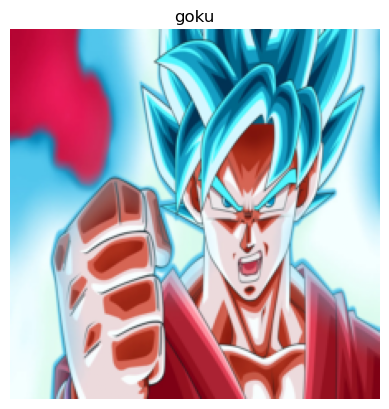

In [103]:
# view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off");

We need to convert the above image shape which is (3, 224, 224) into (196, 768))

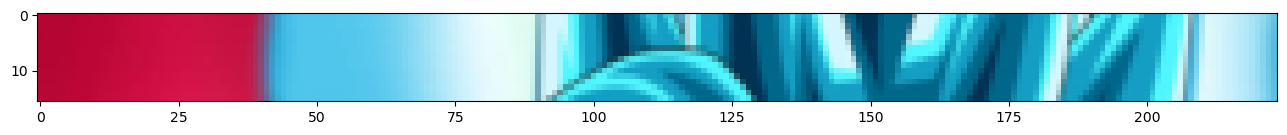

In [104]:
# We can try a portion of the above image into a single top row patch

image_permute = image.permute(1,2,0)

# Index to plot the top row of the image
patch_size = 16 # patch size used in the paper
plt.figure(figsize = (patch_size, patch_size))
# Now we will index on the image permuted created
plt.imshow(image_permute[:patch_size,:, :]) # Indexing upto patch size with entire width and color channels dimensions

Number of patches is 14.0
Shape of 16 pixels x 16 pixels


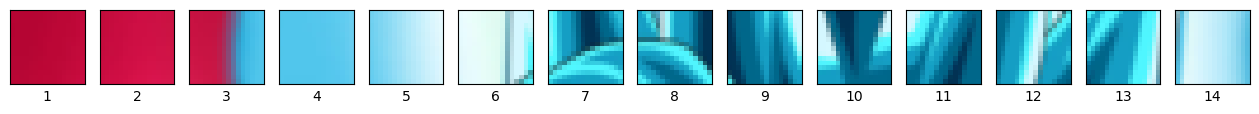

In [105]:
# Now we need to turn the top row into sequence of patches
# we can iterate over the above patch and for every patchsize we can make a cut

img_size = 224
patch_size = 16
num_patches = img_size / patch_size 
assert img_size % patch_size == 0 # Image size must be divisible by patch size
print(f"Number of patches is {num_patches}")
print(f"Shape of {patch_size} pixels x {patch_size} pixels")

# Create series of subplots, 
# we can iterate over the above patch and for every patchsize we can make a cut and plot them individually

fig, axs = plt.subplots(nrows = 1,
                       ncols = img_size // patch_size, # one column for each patch
                       sharex = True,
                        sharey = True,
                       figsize = (patch_size, patch_size))

# Iterate through number of patches in the top row and every for every patch size we make a cut
for i, patch in enumerate(range(0, img_size, patch_size)):
    #print(patch)
    # i will be the number of columns
    axs[i].imshow(image_permute[:patch_size, patch:patch + patch_size, :]);
    axs[i].set_xlabel(i+1) # sets the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches is 14.0
Shape of 16 pixels x 16 pixels
Number of patches per row: 14.0
Number of patches per column: 14.0
Total number of patches: 196.0


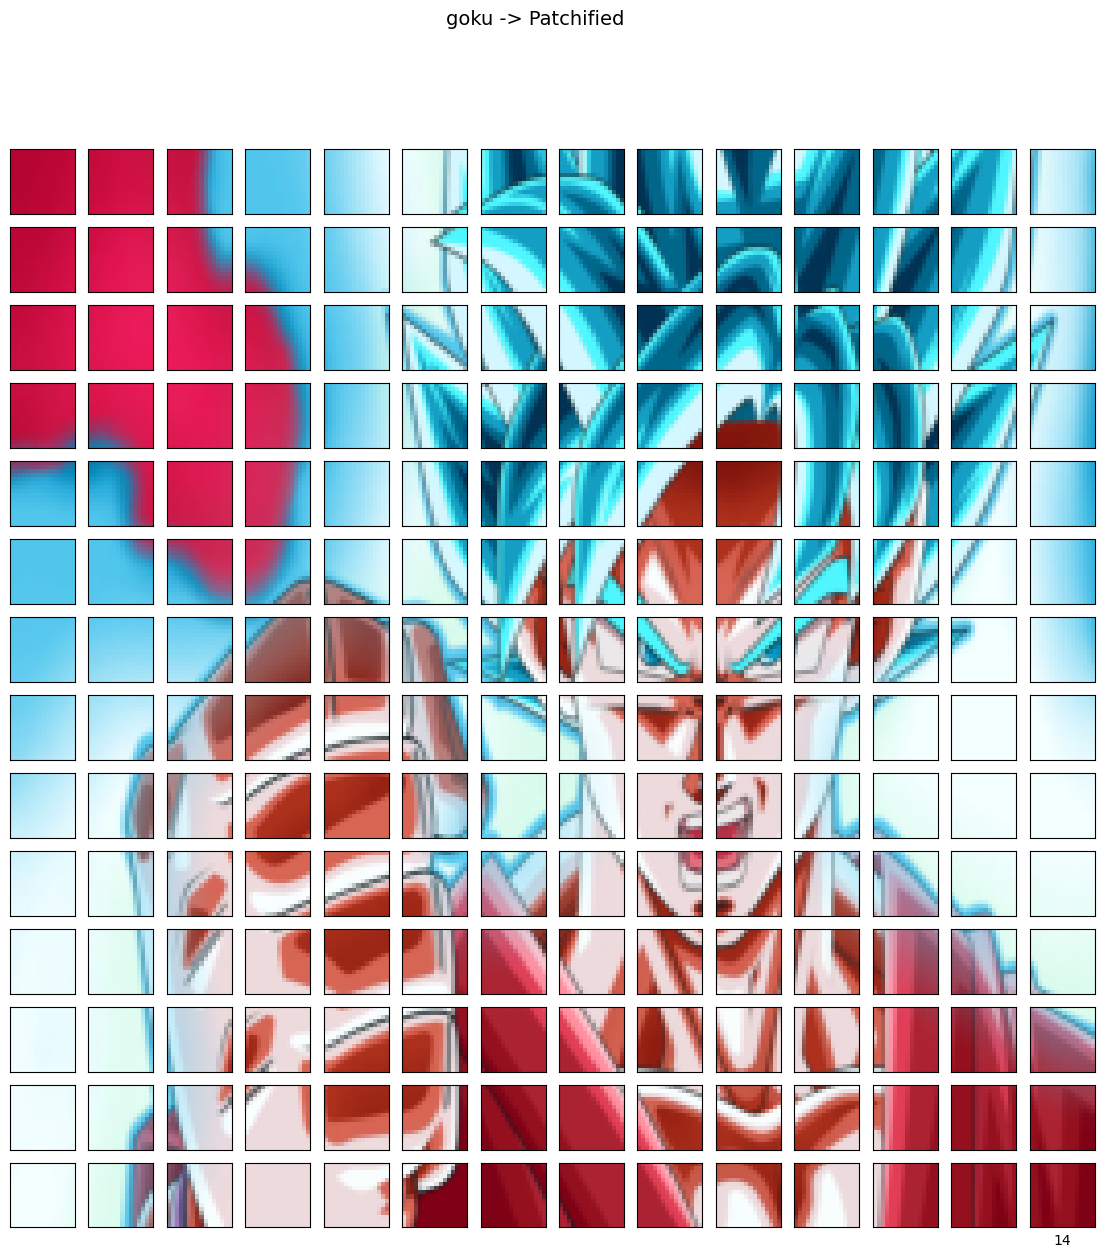

In [106]:
# Stup code to plot whole image as patches

img_size = 224
patch_size = 16
num_patches = img_size / patch_size 
assert img_size % patch_size == 0 # Image size must be divisible by patch size
print(f"Number of patches is {num_patches}")
print(f"Shape of {patch_size} pixels x {patch_size} pixels\
\nNumber of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal number of patches: {num_patches * num_patches}")


# create a series of subplots
fig, axs = plt.subplots(nrows = img_size // patch_size,
                       ncols = img_size // patch_size,
                       figsize = (num_patches, num_patches),
                       sharex = True,
                       sharey = True)

# Loop through heught and width of Image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterates through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): #iterates through width
        # now we need to plot the permuted images over different axes
        axs[i, j].imshow(image_permute[patch_height:patch_height + patch_size, # iterate through height
                         patch_width:patch_width+patch_size, #iterate through width
                         :])

    # setup label info for each subplot(patch)
    axs[i, j].set_ylabel(i+1,
                        rotation = "horizontal",
                        horizontalalignment = "right",
                        verticalalignment = "center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# setup title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)
plt.show()

### Creating Image Patches and turning them into Patch Embeddings
1. We need to flatten our image into a sequence and also turn them into embeddings
2. We can use `torch.nn.Conv2d` and we can set kernel size and stride equal to `patch_size` so that, it slides over each of the patches and we can turn patches into `Embeddings`

Hybrid Architecture. As an alternative to raw image patches, `the input sequence can be formed from feature maps of a CNN {LeCun1989}`. In this hybrid model, the patch embedding projection $E$ (Eq.1) is applied to `patches extracted from a CNN feature map`. As a special case, the patches can have spatial size $1\times1$, which means that the `input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension`. The classification input embedding and position embeddings are added as described above.

In [107]:
# Create cov2d layer to turn image  into patches of learnable feature maps (embeddings)

from torch import nn

patch_size = 16

# Create conv2d layer with hyper params from the ViT Paper
conv2d = nn.Conv2d(in_channels= 3,
                  out_channels = 768,
                    # Output shape from Embedding Layer (Single 1D sequence of patches) : 
                   #(196, 768) - (number_of_patches, embedding_dimension)
                   kernel_size= patch_size,
                   stride = patch_size,
                   padding = 0
                  )
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

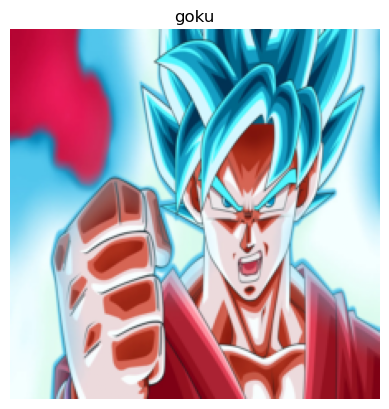

In [108]:
# View a single image 
plt.imshow(image_permute)
plt.title(class_names[label])
plt.axis("off");

In [109]:
# pass a single image through the conv2d layer
image_out_of_conv2d = conv2d(image.unsqueeze(0)) # adding a batch dimension
print(image_out_of_conv2d.shape)

torch.Size([1, 768, 14, 14])


1. 1 batch size with 768 embedding dimension
2. 14 x 14 is the number of image patches
3. 14: This is the height of the output feature maps. Since the Conv2d layer has a stride of 16 (which is equal to the patch size), the output feature maps will have a spatial resolution that is 16 times smaller than the input image. In this case, the input image is likely 224x224 (a common size for ImageNet images), so the output feature maps will have a height of 14 (224 / 16 = 14).
4. 14: This is the width of the output feature maps, which is the same as the height (14) since the Conv2d layer is using a square kernel (16x16) with a stride of 16.

#### Whats happening ?

1. We have passed a sample image into the conv2d layer. The output received shape is `torch.Size([1, 768, 14, 14])`. This will be the input to the Vision Transformer. Its a learnable param, the gradient required for this tensors will be True.
2. Imagine as now we got the patches of images, we want to flatten the images into a single tensor. Which is our image tensor now has height and width and dimension of x number of patches, we want to flatten the height and width of the image into a single sequence of vector. The height and width are our feature maps which we want to perform flattening on.

Showing random convolution feature maps indexes [217, 567, 290, 574, 509]


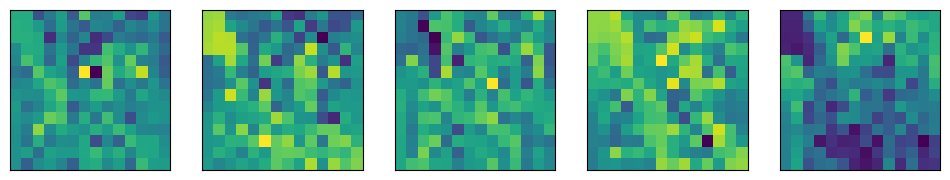

In [114]:
# plot random convolution feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k = 5)
print(f"Showing random convolution feature maps indexes {random_indexes}")

# Now we will use the random indexes to index on the image_out_of_conv2d and visualize the embedding dimensions
fig, axs = plt.subplots(nrows = 1, ncols= 5, figsize = (12,12))

for i, idx in enumerate(random_indexes):
    img_conv_feature = image_out_of_conv2d[:, idx, :, :] # we are indexing on the output tensor of the sample image passed through the conv2d layer
    axs[i].imshow(img_conv_feature.squeeze().detach().numpy()) # remove batch dimensions and remove grad tracking and comverting the tensor into numpy for matplotlib
    axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

#### This is how behind the scenes the convolution over the image happens and how the feature maps looks like.

In [115]:
# how a single feature map looks like
single_feature_map = image_out_of_conv2d[:,2,:,:]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 1.7042e-01,  1.9593e-01,  1.2712e-01,  2.2108e-01,  2.1833e-01,
            2.5920e-01,  2.5092e-01,  2.2555e-02,  8.6727e-02,  2.4185e-01,
            3.6623e-01,  9.3886e-02,  3.0541e-01,  1.9290e-01],
          [ 1.8485e-01,  2.1664e-01,  1.1194e-01,  2.6655e-01,  2.0999e-01,
            2.0648e-01,  2.0831e-01,  6.9156e-02,  3.2984e-01,  3.0147e-02,
            2.1322e-01,  1.5056e-01,  1.1383e-01,  2.6574e-01],
          [ 1.9366e-01,  2.2689e-01,  2.2672e-01,  2.1155e-01,  2.2703e-01,
            1.4543e-01,  3.7411e-01,  2.9788e-01, -6.3065e-02,  7.0678e-03,
            1.4641e-01,  2.1634e-01,  1.3891e-01,  3.4162e-01],
          [ 2.4576e-01,  1.8311e-01,  2.3957e-01,  2.9239e-01,  1.9184e-01,
            2.3267e-01,  6.6554e-02, -1.2441e-02,  1.0604e-03,  4.8762e-01,
            1.7885e-01, -7.2765e-02,  4.2631e-01,  1.5582e-01],
          [ 1.2318e-01,  1.1710e-01,  2.0873e-01,  2.4461e-01,  2.0390e-01,
            2.5689e-01,  1.4965e-01,  2.1645e-01,  2.2573e-0

##### This is how a single feature map looks like and we could see all the the above are learnable params with gradient tracking = True

### Flattening the patch embedding with `torch.nn.Flatten()` -> [batch_size, number_of_patches, embedding_dim]

In [116]:
# what our current image is 
print(image_out_of_conv2d.shape)

torch.Size([1, 768, 14, 14])


##### What we want to achieve is (1, 768, 196)

In [119]:
from torch import nn

flatten_layer = nn.Flatten(start_dim= 2,
                          end_dim= 3)

flatten_layer(image_out_of_conv2d).permute(0,2,1).shape
# we could see the below shape is the shape we are looking for the image to pass to transformer layer

torch.Size([1, 196, 768])

Original Image Shape: torch.Size([3, 224, 224])
Shape of Image out of Conv2d layer is torch.Size([1, 768, 14, 14])
Raw Image shape of Image out of flattened layer is torch.Size([1, 768, 196])
Permuted Image shape out of Flattened layer is torch.Size([1, 196, 768])


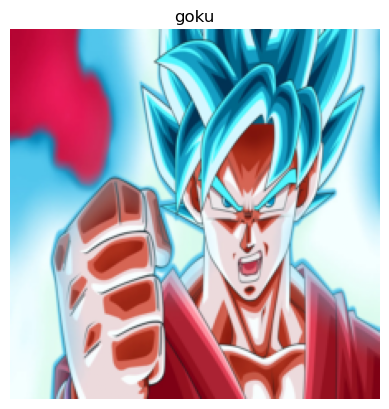

In [133]:
# put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")
print(f"Original Image Shape: {image.shape}")

# Turn image into feature maps by passing into conv2d layer
image_out_of_conv_layer = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Shape of Image out of Conv2d layer is {image_out_of_conv_layer.shape}")

#Flatten the image
flattened_image = flatten_layer(image_out_of_conv_layer)
print(f"Raw Image shape of Image out of flattened layer is {flattened_image.shape}")
image_conv_flattened_permuted = flattened_image.permute(0,2,1)
print(f"Permuted Image shape out of Flattened layer is {image_conv_flattened_permuted.shape}")

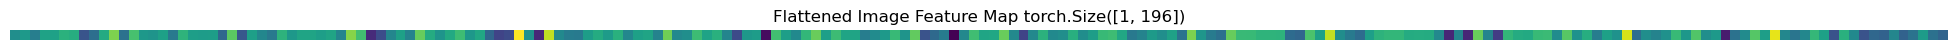

In [136]:
# Get a single flattened feature map
single_flattened_image_feature_map = image_conv_flattened_permuted[:, :, 2]

# plot the flattened feature map
plt.figure(figsize = (25,25))
plt.imshow(single_flattened_image_feature_map.detach().numpy())
plt.title(f"Flattened Image Feature Map {single_flattened_image_feature_map.shape}")
plt.axis("off");

### Turning the ViT patch embedding layer into a pytorch module

1. Create a class that inherits the pytorch `nn.Module`
2. Define the hyperparameters -> input color channels, embedding dimensions, patch size
3. Create a `Conv2d` to turn an inmage into embedding patches
4. Create a `Flatten` layer to flatten the output from the Conv2d layer.
5. Define a `forward()` method which defines the forward computation
6. Check the output shape of the layer reflects the required output shape of patch embedding

In [149]:
# 1. Create a class that inherits nn.Module
class PatchEmbedder(nn.Module):
    #2. Define the hyperparams
    def __init__(self,
                in_channels:int = 3,
                patch_size:int = 16,
                embedding_dim:int = 768):
        super().__init__()
        self.patch_size = patch_size

        # 3. Create a conv2d layer to turn image into embedding patches
        self.embedder = nn.Conv2d(in_channels = in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size= patch_size,
                                 stride = patch_size,
                                 padding = 0)

        # 4. Craete a FLatten layer to flatten the output from conv2d layer
        self.flatten = nn.Flatten(start_dim=2,
                                 end_dim=3)

    #5. define a forward method
    def forward(self, x):
        # create assertion to check if the inputs are in the correct shape image.shape[-1] = 224
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input shape must be divisible with the patch size. Input shape - {image_resolution}, patch_size - {self.patch_size}"

        # perform forward pass
        x_patched = self.embedder(x)
        x_flattened = self.flatten(x_patched)

        #6. Return the putput from the flatter layer in the right order( btach_size, number_of_patches, embedding_dimension)
        return x_flattened.permute(0,2,1)
        

In [150]:
set_seeds(95)

# Create an instance of the PatchEmbedder
patcher_embedder = PatchEmbedder(in_channels=3,
                                embedding_dim=768,
                                patch_size = 16)

# pass single image into patch_embedder
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedder_image = patcher_embedder(image.unsqueeze(0))
print(f"Output shape of the image from patch_embedder class is - {patch_embedder_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output shape of the image from patch_embedder class is - torch.Size([1, 196, 768])


In [151]:
# check if assertion is working
rand_image_tensor_good = torch.rand(1, 3, 224, 224)
rand_image_tensor_bad = torch.rand(1, 3, 225,236)

In [152]:
patcher_embedder(rand_image_tensor_good)

tensor([[[-0.0090,  0.3034, -0.2722,  ..., -0.4552, -0.2373,  0.0834],
         [-0.1364, -0.1809,  0.3161,  ..., -0.2236, -0.7881,  0.0234],
         [-0.3071,  0.3741, -0.0382,  ..., -0.5247, -0.6313,  0.0546],
         ...,
         [-0.1407,  0.3950, -0.3307,  ..., -0.2672, -0.2781,  0.3350],
         [-0.5947, -0.0273, -0.1004,  ..., -0.3375, -0.4686,  0.1227],
         [-0.1936,  0.1450, -0.1481,  ..., -0.5009, -0.7645,  0.1567]]],
       grad_fn=<PermuteBackward0>)

In [153]:
patcher_embedder(rand_image_tensor_bad)

AssertionError: Input shape must be divisible with the patch size. Input shape - 236, patch_size - 16

### Creating a class token embedding
#### Want to prepend a learnable class token to the start of the patch embedding

In [154]:
patch_embedder_image.shape

torch.Size([1, 196, 768])

##### we want to prepend a learnable parameter to the 0th position in the number of patches dimension. After prepending, the shape will be ([1, 197, 768])

In [156]:
# get the batch size and embedding dimension shape values
batch_size = patch_embedder_image.shape[0]
embedding_dimension = patch_embedder_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

##### create class token embedding as a learnable parameter that shares the same size as the embedding dimension,
##### as we need to add the learnable parameter across all the embedding dimensions to the patch dimension

#####  In PyTorch, nn.Parameter is a learnable parameter, also known as a model parameter or a trainable parameter. When you create a PyTorch module (e.g., nn.Module) and define its parameters using nn.Parameter, these parameters are automatically registered as learnable parameters. This means that during training, the optimizer will update these parameters to minimize the loss function.


In [166]:
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                          requires_grad= True)
class_token.shape

torch.Size([1, 1, 768])

In [167]:
patch_embedder_image.shape

torch.Size([1, 196, 768])

In [168]:
# The class_token is added across 0th position of patch_embedder_image across all the 768 dimensions

In [170]:
patch_embedder_image_class_embedding = torch.cat((class_token, patch_embedder_image),
                                                dim = 1) #concat across number of patche dimension

print(patch_embedder_image_class_embedding[0])
# we could see a series of randn at the 0th index on the number of patches dimension
print(f"Sequence of embedding with class token prepended to the 0th index with shape: {patch_embedder_image_class_embedding.shape}")

tensor([[-0.0449, -0.8189,  0.5711,  ..., -0.3416, -0.7625, -0.9260],
        [ 0.1097,  0.3233,  0.1531,  ..., -0.1636, -0.4344,  0.4823],
        [ 0.1137,  0.3453,  0.1546,  ..., -0.2061, -0.4881,  0.5303],
        ...,
        [-0.1308,  0.1781,  0.1467,  ..., -0.3768, -0.2861,  0.4781],
        [ 0.0357,  0.2264,  0.1678,  ..., -0.1384, -0.3492,  0.3496],
        [ 0.0719,  0.2383,  0.1612,  ..., -0.1764, -0.2943,  0.3771]],
       grad_fn=<SelectBackward0>)
Sequence of embedding with class token prepended to the 0th index with shape: torch.Size([1, 197, 768])


### Creating a Position Embedding
##### We want to create a 1D learnable position embedding of shape (N+1) x Embedding Dimension

calculate N, number of patches ----->   $N = \frac{HW}{P^2}$ is the resulting number of patches

In [171]:
number_of_patches = int((height * width)/ patch_size ** 2)
number_of_patches

196

In [191]:
# we can get embedding dimension
embedding_dimension = patch_embedder_image_class_embedding.shape[-1]

# create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(batch_size,
                                            number_of_patches +1,
                                            embedding_dimension), requires_grad= True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[-0.5241, -0.2145,  2.1438,  ..., -0.9539,  1.0229,  0.0259],
          [-0.3109,  1.6452, -0.3101,  ..., -0.6258,  0.1057,  0.6118],
          [ 0.8738,  1.6115,  0.2685,  ...,  0.9861, -0.4300, -0.2430],
          ...,
          [-1.0497,  1.0715,  1.0402,  ..., -0.7231, -0.8426,  0.4104],
          [-0.9465,  0.8583, -0.8387,  ...,  0.9745,  0.9111,  1.3693],
          [-0.7875,  1.1369, -0.3048,  ...,  0.5562, -0.1683, -1.0529]]],
        requires_grad=True),
 torch.Size([1, 197, 768]))

In [178]:
# Add the position embedding to patch_embedder_image_class_embedding
patch_and_position_embedding = position_embedding + patch_embedder_image_class_embedding

print(patch_and_position_embedding[0])
print(f"Patch and Position Embedding shape is {patch_and_position_embedding.shape}")

tensor([[ 0.8286,  1.3510, -1.2243,  ..., -2.1388, -3.2393, -0.6230],
        [ 0.7740,  0.9100,  1.5867,  ..., -0.1852, -1.6785,  1.7363],
        [ 0.5861,  0.5468,  0.5375,  ...,  0.2959, -1.6605,  1.0416],
        ...,
        [ 0.6979,  0.4288,  0.8096,  ...,  0.4222, -0.4030, -1.0349],
        [ 0.4702,  0.9553,  1.5226,  ..., -1.2087, -1.4192, -0.1161],
        [-0.3548,  1.6874, -1.4954,  ...,  1.1669,  0.8574,  0.6645]],
       grad_fn=<SelectBackward0>)
Patch and Position Embedding shape is torch.Size([1, 197, 768])


### Putting it all together : From Image to Embedding

In [190]:
# set seeds
set_seeds()

# 1. set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Original Image Tensor shape: {image.shape}")
image_height, image_width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Image with batch dimension added: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedder(in_channels=3,
                                     embedding_dim=768,
                                     patch_size = patch_size)


# 5. Pass Image through patch embedding layer
patch_embedded_image = patch_embedding_layer(x)
print(f"Shape of the input image passed through patch embedded layer: {patch_embedded_image.shape}")

# 6. Create class token embedding
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), 
                           requires_grad= True)

print(f"Created class token shape is : {class_token.shape}")

# 7. Prepend the class token to the patch_embedded image
patch_class_embedded_image = torch.cat((class_token, patch_embedded_image),
                                      dim = 1)

print(f"The shape of the embedded image with class token added: {patch_class_embedded_image.shape}")

# 8. Create position embedding token
number_of_patches = int((image_height * image_width)/ patch_size **2)
position_embeddings = nn.Parameter(torch.randn(batch_size,
                                              number_of_patches +1,
                                              embedding_dimension), requires_grad= True)

# 9. Add the position embedding to the patch class embedded image
embedded_patch_position_image = patch_class_embedded_image + position_embeddings
print(f"Embedded Image with class and position embedding added: {embedded_patch_position_image.shape}")

Original Image Tensor shape: torch.Size([3, 224, 224])
Image with batch dimension added: torch.Size([1, 3, 224, 224])
Shape of the input image passed through patch embedded layer: torch.Size([1, 196, 768])
Created class token shape is : torch.Size([1, 1, 768])
The shape of the embedded image with class token added: torch.Size([1, 197, 768])
Embedded Image with class and position embedding added: torch.Size([1, 197, 768])


## Equation 2 : Multi-Headed Self Attention (MSA Block)

* Multi-Headed Self Attention - Which part of the sequence should pay the most attention to itself.
* In our case, which patch of the image should pay attention to which patch of other images
* We want our Neural Network (ViT) to learn this relationship.
* To replicate MSA in pytorch we can use (https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
* Layer Normalization - Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
* Normalization - We want everything to have the same mean and same distribution.
* In LayerNorm - The mean and standard-deviation are calculated over the last D dimensions, where D is the dimension of normalized_shape. *In our case D dimension is the embedding_dimension*

##### Difference between Batch Normalization and LayerNorm -

Batch Normalization (BN):
In BN, the normalization statistics (mean and variance) are computed across the batch dimension. This means that BN calculates the mean and variance of the activations for each feature (channel) across all samples in the batch. The normalization is then applied to each sample in the batch, using these batch-level statistics.


Layer Normalization (LN):
In LN, the normalization statistics are computed across the feature dimension (i.e., the summed inputs to the neurons within a hidden layer). This means that LN calculates the mean and variance of the activations for each sample, across all features (channels) in the layer. The normalization is then applied to each sample, using these layer-level statistics.


The key difference is that BN introduces dependencies between training cases (samples) in the batch, since the normalization statistics are computed across the batch dimension. This means that the normalization applied to one sample depends on the other samples in the batch.


In contrast, LN does not introduce such dependencies, since the normalization statistics are computed independently for each sample, across the feature dimension. This makes LN more suitable for recurrent neural networks (RNNs) and transformers, where the same layer is applied to different positions in the input sequence.


##### Analogy - 

Normalizing along the embedding dimension is like making all the stairs in a staircase the same size. Here's how this analogy works:

Staircase = Embedding Space
* Imagine a staircase with multiple stairs, each representing a dimension in the embedding space. Just as a staircase has multiple stairs that lead to different levels, an embedding space has multiple dimensions that capture different aspects of the input data.

Stair Size = Magnitude of Embedding Values
* The size of each stair represents the magnitude of the embedding values in that dimension. Just as some stairs might be taller or shorter than others, some dimensions in the embedding space might have larger or smaller values.

Normalizing along Embedding Dimension = Making Stairs the Same Size
* When we normalize along the embedding dimension, we're essentially making all the stairs the same size. This means that we're scaling the embedding values in each dimension so that they have the same magnitude.

Why is this helpful?
* By making all the stairs the same size, we're ensuring that each dimension in the embedding space contributes equally to the representation of the input data. 

This helps to:
* Reduce the dominance of any single dimension
* Improve the stability of the embedding space
* Enhance the ability of the model to capture subtle patterns in the data

What if we didn't normalize?
* If we didn't normalize along the embedding dimension, it would be like having stairs of vastly different sizes. Some dimensions would dominate the representation, while others would be negligible. 

This could lead to:
* Unstable or biased representations
* Difficulty in capturing nuanced patterns in the data

By normalizing along the embedding dimension, we're creating a more balanced and stable representation of the input data, which can improve the performance of downstream tasks.

In [196]:
class MultiHeadedSelfAttentionBlock(nn.Module):
    """Creates a Multi-Headed Self Attention Block ("MSA Block")"""

    def __init__(self,
                embedding_dim: int = 768, # Hidden Size (D) embedding dimension from Table 1 from ViT Base
                num_heads: int = 12, # Heads from table 1 from ViT paper
                attn_dropout: int = 0):

        super().__init__()

        # Create the LayerNorm (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create Multi Headed SelfAttention (MSA) layer
        self.multi_headed_selfattention = nn.MultiheadAttention(embed_dim= embedding_dim,
                                                               num_heads = num_heads,
                                                               dropout= attn_dropout,
                                                               batch_first= True) # batch_first – If True, then the input and output tensors are provided as (batch, seq, feature).


    def forward(self, x):
            x = self.layer_norm(x)
            # multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
            # attn_output, attn_output_weights = multihead_attn(query, key, value)
            attention_output, _ = self.multi_headed_selfattention(query = x,
                                                                 key = x,
                                                                 value = x,
                                                                 need_weights = False)
            # need_weights (bool) – If specified, returns attn_output_weights in addition to attn_outputs. Set need_weights=False 
            # to use the optimized scaled_dot_product_attention and achieve the best performance for MHA. Default: True.

            return attention_output

In [198]:
## Create an Instance of MSA Block
msa_block = MultiHeadedSelfAttentionBlock(embedding_dim= 768,
                                         num_heads= 12,
                                         attn_dropout= 0)


## Pass the embedded_patch_position_image through the msa_block
patched_image_through_msa_block = msa_block(embedded_patch_position_image)
print(f"Input shape of embedded_patch_position_image through MSA Block: {embedded_patch_position_image.shape}")
print(f"Output shape of image from MSA Block: {patched_image_through_msa_block.shape}")

Input shape of embedded_patch_position_image through MSA Block: torch.Size([1, 197, 768])
Output shape of image from MSA Block: torch.Size([1, 197, 768])


In [200]:
embedded_patch_position_image, patched_image_through_msa_block

(tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
          [-1.1416,  0.6263, -1.0925,  ..., -0.1808, -2.4524, -0.5219],
          [-2.0874, -0.4020, -1.3617,  ...,  1.9690,  0.2623,  0.2282],
          ...,
          [ 0.9487,  0.6448,  0.1825,  ..., -0.2662,  1.0247,  1.0169],
          [-0.3736, -0.5898, -0.3040,  ..., -0.4137,  0.1258,  1.4984],
          [-0.5390, -0.0821,  1.5410,  ..., -0.3170,  1.4039, -0.1992]]],
        grad_fn=<AddBackward0>),
 tensor([[[ 0.2798,  0.0608,  0.1489,  ..., -0.3161,  0.2036, -0.1213],
          [ 0.2806,  0.0574,  0.1622,  ..., -0.3318,  0.2323, -0.0744],
          [ 0.2823,  0.0783,  0.1533,  ..., -0.3327,  0.2190, -0.1073],
          ...,
          [ 0.2671,  0.0769,  0.1544,  ..., -0.3357,  0.2179, -0.1116],
          [ 0.2961,  0.0339,  0.1103,  ..., -0.3178,  0.2232, -0.1021],
          [ 0.2991,  0.0589,  0.1444,  ..., -0.2941,  0.2209, -0.1037]]],
        grad_fn=<TransposeBackward0>))

### 6. MultiLayer Perceptron (MLP Block)

* Multi-Layer Perceptron (MLP) MLP, also known as the Feed-Forward network (FFN), consists of two linear layers and a GELU nonlinearity in Transformers.
* Layers can be multiple or even one hidden layer
* Layers can mean fully-connetced, dense, linear, feed-forward. All or often similar names. In Pytorch they are often called as `torch.nn.Linear()`
* MLP number of hidden units = MLP Size in Table 1
* The Gaussian Error Linear Unit (GELU) is a neural network activation function that weights inputs by their percentile, rather than their sign. It's often described as a smoother version of the Rectified Linear Unit (ReLU) activation function.
* Reference Link for MLP Block Structure -  https://www.researchgate.net/figure/The-MLP-architecture-with-two-fully-connected-layers-and-a-Gaussian-error-linear-unit_fig3_355148120
* Dropout - In a transformer model, dropout is a regularization technique that helps prevent overfitting by randomly masking a percentage of the layer's outputs as 0. Dropout is used during training time, but not during inference time
* Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings.
* Value for Dropout is available in Table 3, for base model dropout = 0.1

##### In Pseudocode:
$x = linear layer -> non-linear layer -> dropout layer -> linear layer -> dropout$

In [201]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim:int = 768,
                mlp_size:int = 3072,
                attn_dropout:float = 0.1):
        super().__init__() 

        # Create the LayerNorm (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP Block
        self.mlp_block = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                     out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p = attn_dropout),
            nn.Linear(in_features=mlp_size,
                     out_features=embedding_dim),
            nn.Dropout(p = attn_dropout)
        )

    def forward(self, x):
        return(self.mlp_block(self.layer_norm(x)))

In [202]:
# Create instance of MLP Block
mlp_block = MLPBlock(embedding_dim=768,
                    mlp_size=3072,
                    attn_dropout=0.1)

### 7. Creating the Transformer Block

The Transformer Encoder is an alternate blocks of MSA(Eq 2) and MLP(Eq 3) with Residual connections between each block.

* Encoder -> Turns a sequence of input into learnable representations.
* Decoder -> Turns the learnable represtations back to some sort of sequence of representation.
* Residual Connection -> Adds a layer input to its subsequent output, this allows the creation of deeper network models (prevents weights from getting too small.)

##### x_input -> MSA_block -> [MSA_Block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input]

In [205]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                embedding_dim:int = 768, # Hidden Size D for ViT Base
                num_heads:int = 12,
                attention_dropot:int = 0,
                mlp_droput:int = 0.1,
                mlp_size:int = 3072):
        super().__init__()

        # Create MSA block (eq 2)
        self.msa_block = MultiHeadedSelfAttentionBlock(embedding_dim = embedding_dim,
                                                      num_heads=num_heads,
                                                      attn_dropout=attention_dropot)

        # Create MLP Block (eq 3)
        self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                                 mlp_size=mlp_size,
                                 attn_dropout=attention_dropot)


    # Define the forward method
    def forward(self, x):
        x = self.msa_block(x) + x #resiudal connection
        x = self.mlp_block(x) + x
        return x
        

In [209]:
# Create an Instance of Transformer Encoder Block
transformer_encoder_block = TransformerEncoderBlock()

# Get Summary using torch.info
summary(model = transformer_encoder_block,
       input_size= (1, 197, 768), #(batch_size, number_of_patches, embedding_dimensions)
       col_names = ["input_size", "output_size", "num_params","trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadedSelfAttentionBlock (msa_block)                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multi_headed_selfattention)       --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_block)                                [1, 197, 768]        [1, 197, 7

### Create a Tramsformer Encoder Layer with in-built Pytorch Layer

https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

In [217]:
# create the same Transformer Encoder Block like above using torch.nn.TransformerEncoderLayer()

torch_transformer_encoder_block = nn.TransformerEncoderLayer(d_model = 768, #embedding size from table 1
                                                nhead= 12, #heads from table 1
                                                dim_feedforward= 3072, #MLP size from table 1
                                                dropout = 0.1,
                                                activation = "gelu",
                                                batch_first = True,
                                                norm_first= True)
torch_transformer_encoder_block

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [220]:
# Get Summary using torch.info
summary(model = torch_transformer_encoder_block,
       input_size= (1, 197, 768), #(batch_size, number_of_patches, embedding_dimensions)
       col_names = ["input_size", "output_size", "num_params","trainable"],
       col_width = 20,
       row_settings = ["var_names"],
       verbose= 2)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [222]:
self_attn_params = sum(p.numel() for p in torch_transformer_encoder_block.self_attn.parameters())
ffn_params = sum(p.numel() for p in torch_transformer_encoder_block.linear1.parameters()) + sum(p.numel() for p in torch_transformer_encoder_block.linear2.parameters())

# Estimate total parameters
total_params = sum(p.numel() for p in torch_transformer_encoder_block.parameters())
print(f"Estimated total parameters: {total_params}")

Estimated total parameters: 7087872


#### Eq. 4

A learnable embedding is prepended to the sequence of embedded patches, similar to BERT's [class] token. This embedding is denoted as z_0_0 = x_class.
The state of this embedding at the output of the Transformer encoder (after L layers) is used as the image representation, denoted as y (Eq. 4).
During both pre-training and fine-tuning, a classification head is attached to the image representation z_0_L.
The classification head is implemented differently depending on the stage:
During pre-training, the classification head is a multi-layer perceptron (MLP) with one hidden layer.
During fine-tuning, the classification head is a single linear layer.
The idea is that the image representation y learned by the Transformer encoder captures the essential features of the input image, and the classification head can be used to predict the class label based on this representation.
By using a learnable embedding as the image representation, ViT can effectively capture the global context of the image and perform well on image classification tasks. The use of a classification head with a different architecture during pre-training and fine-tuning allows the model to adapt to different tasks and datasets.

### 8. Putting it all together to create ViT

In [247]:
# create ViT class
class ViT(nn.Module):
    def __init__(self,
                image_size: int = 224, # Table 3 from ViT paper
                in_channels:int = 3,
                patch_size:int = 16,
                num_transformer_layers:int = 12, # Table 1 for layers from paper
                embedding_dim:int = 768, # hidden size D from Table 1 
                mlp_size:int = 3072, # table 1
                num_heads:int = 12, # table 1
                attention_dropout:int = 0,
                mlp_dropout:int = 0.1,
                embedding_dropout:int = 0.1,
                num_classes:int = 1000): # num_classes is as per the ViT paper, we can customize the class value

        super().__init__()

        # make an assertion to make sure the image size is compatible with the patch size
        assert image_size % patch_size == 0, f"Image size must be divisible by patch size, Image Size: {image_size} and Patch Size: {patch_size}"

        # Calculate the "N" number of patches, N = HW/P**2 is the resulting number of patches
        self.num_patches = int((image_size*image_size) // patch_size**2)

        # Create learnable class embeddings which needs to go at the front of the patch embeddings
        self.class_embeddings = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                            requires_grad= True)

        # Create learnable position embeddings
        self.position_embeddings = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad= True)

        # create embedding dropout value
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)

        # create patch embedding layer
        self.patch_embedding = PatchEmbedder(in_channels=in_channels,
                                            patch_size=patch_size,
                                            embedding_dim=embedding_dim)

        # Create the transformer encoder block
        self.transformer_encoder = nn.Sequential(* [TransformerEncoderBlock(embedding_dim = embedding_dim,
                                                                           num_heads = num_heads,
                                                                           mlp_droput=mlp_dropout,
                                                                           mlp_size=mlp_size) for _ in range(num_transformer_layers)])
        # * helps to turn all the layers in the list comprehension into a sequntial layer
        # we only need to pass the classification token through the MLP Head

        
        # Create classifier head
        # The classification head is implemented by a MLP with one hidden layer at pre-training 
        # time and by a single linear layer at fine-tuning time.
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features= embedding_dim, # the output from the transformer encoder shape
                     out_features=num_classes)
            )

    def forward(self, x):

        # get the batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size( Equation 1 )
        # we want the class embedding to prepend across all the images over all the batches. 
        # For this we use .expand() -1 means to infer the dimensions
        # we want to create x_patch_embedding for each image in the batch and 
        # prepend class token for each image in the batch
        self.class_token = self.class_embeddings.expand(batch_size, -1, -1)

        # create patch embedding
        x = self.patch_embedding(x)

        # concat class token to the patch embeddings
        x = torch.cat((self.class_token, x), dim = 1) #(batch_size, number_of_batches, embedding_dimension)

        # add position embeddings to class token and patch embeddings
        x = x + self.position_embeddings
        
        # Dropout, when used, is applied after every dense layer except for the the qkv-projections and 
        # directly after adding positional- to patch embeddings.
        x = self.embedding_dropout(x)

        # pass position and patch embedding to the transformer encoder ( Equation 2 , Equation 3 )
        x = self.transformer_encoder(x)

        # Put 0th index logit through the classifer ( Equation 4 )
        x = self.classifier(x[:, 0])

        return x

In [248]:
# # Create class token embedding and expand it to match the batch size( Equation 1 )
# batch_size = 32
# embedding_dim = 768

# class_token = nn.Parameter(data = torch.randn(1, 1, embedding_dim), requires_grad= True)
# print(class_token.shape)
# # now the above is just for 1 image in 1 batch.
# # But we want the class embedding to prepend across all the images over all the batches. For this we use .expand()
# # -1 means to infer the dimensions
# class_token_expanded = class_token.expand(batch_size, -1, -1)
# print(class_token_expanded.shape)
# # Now we could see we expanded the class token across all the images in a  batches

In [249]:
vit = ViT()
#vit

In [254]:
# Create a random image to pass into the Vision Transformer
random_image_tensor = torch.randn(1,3,224,224)

# Create instance of the model with num of classes we have 
vit = ViT(num_classes= len(class_names))

# pass the random image tensor through the model
vit(random_image_tensor)

tensor([[ 0.7786,  0.0231, -0.0968,  0.4297]], grad_fn=<AddmmBackward0>)

### Visual Summary of the ViT Model

In [253]:
# Get Summary using torch.info
summary(model = ViT(num_classes=len(class_names)),
       input_size= (1, 3, 224, 224), #(batch_size, color_channels, height_image, width_image)
       col_names = ["input_size", "output_size", "num_params","trainable"],
       col_width = 15,
       row_settings = ["var_names"])

Layer (type (var_name))                                                Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                              [1, 3, 224, 224] [1, 4]          152,064         True
├─PatchEmbedder (patch_embedding)                                      [1, 3, 224, 224] [1, 196, 768]   --              True
│    └─Conv2d (embedder)                                               [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
│    └─Flatten (flatten)                                               [1, 768, 14, 14] [1, 768, 196]   --              --
├─Dropout (embedding_dropout)                                          [1, 197, 768]   [1, 197, 768]   --              --
├─Sequential (transformer_encoder)                                     [1, 197, 768]   [1, 197, 768]   --              True
│    └─TransformerEncoderBlock (0)                                     [1, 197, 768]   [1, 197, 768]   --              True
│ 

### 9. Creating an Optimizer and loss function

* Adam Optimizer is used in the paper (section 4, training & fine-tuning) with β1 = 0.9, β2 = 0.999 and apply a high weight decay of 0.1.
* Weight Decay - Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function. loss = loss + weight decay parameter * L2 norm of the weights.
* Regularization - Prevents Overfitting

In [255]:
# optimizer = torch.optim.Adam(params=vit.parameters(),
#                             lr = 1e-3,
#                             betas = (0.9, 0.999),
#                             weight_decay=0.1)

# loss_fn = torch.nn.CrossEntropyLoss()

### Training our ViT Model

In [256]:
from going_modular import engine

In [258]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                            lr = 1e-3,
                            betas = (0.9, 0.999),
                            weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model = vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.2608 | train_acc: 0.2618 | test_loss: 1.7454 | test_acc: 0.2292
Epoch: 2 | train_loss: 1.5770 | train_acc: 0.2932 | test_loss: 1.9227 | test_acc: 0.3542
Epoch: 3 | train_loss: 1.6779 | train_acc: 0.2248 | test_loss: 1.5224 | test_acc: 0.2361
Epoch: 4 | train_loss: 1.4671 | train_acc: 0.2476 | test_loss: 1.4541 | test_acc: 0.2292
Epoch: 5 | train_loss: 1.4104 | train_acc: 0.2618 | test_loss: 1.3895 | test_acc: 0.2292
Epoch: 6 | train_loss: 1.4190 | train_acc: 0.2389 | test_loss: 1.4274 | test_acc: 0.2361
Epoch: 7 | train_loss: 1.4187 | train_acc: 0.2405 | test_loss: 1.3941 | test_acc: 0.2292
Epoch: 8 | train_loss: 1.4078 | train_acc: 0.2704 | test_loss: 1.4036 | test_acc: 0.2292
Epoch: 9 | train_loss: 1.4124 | train_acc: 0.2332 | test_loss: 1.4293 | test_acc: 0.2292
Epoch: 10 | train_loss: 1.4143 | train_acc: 0.2545 | test_loss: 1.4572 | test_acc: 0.2292


### What the model is missing and how can the model performance be improved?

1. Data and Compute - ViT is trained on millions of images while our model is trained on 100-200 images.
2. Learning Rate Warmup - As the model gets closer to convergence, start to lower the learning rate.
3. Gradient Clipping - Prevent gradients from getting too long

#### Plotting the results

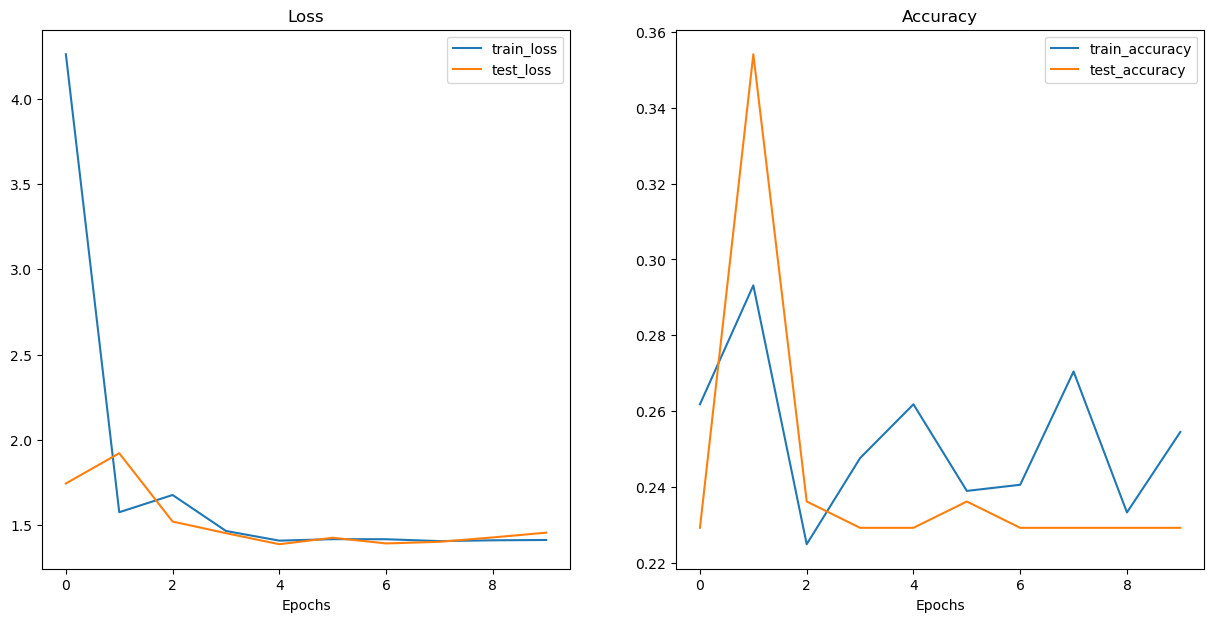

In [259]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

### 10. Using a pretrained ViT from `torchvision.models` for better results

Using a pretrained model which is already trained on larger dataset on custom dataset often give better results.
##### Why use pretrained model?
1. Dataset is small.
2. Limited Compute
3. Get better results sometimes

### Preapre a pretrained ViT model to use with Classification - DBZ Character Classification

In [260]:
# get pretrained weights for vit base
pretrained_vit_model_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # .DEFAULT = best available model weights


# Setting up ViT model instance with pretrained weights
vit_pretrained = torchvision.models.vit_b_16(weights = pretrained_vit_model_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /Users/venu/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|████████████████████████████████████████| 330M/330M [00:14<00:00, 24.3MB/s]


In [264]:
# With our feature extractor model, we want to keep the weights frozen and modify the classification layer

In [266]:
# vit_pretrained
# (heads): Sequential(
#     (head): Linear(in_features=768, out_features=1000, bias=True)

In [267]:
for parameter in vit_pretrained.parameters():
    parameter.requires_grad = False

In [270]:
# Update the classifier head
set_seeds()
vit_pretrained.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Get Summary using torch.info
summary(model = vit_pretrained,
       input_size= (1, 3, 224, 224), #(batch_size, color_channels, height_image, width_image)
       col_names = ["input_size", "output_size", "num_params","trainable"],
       col_width = 15,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 4]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

#### Preparing data for pretrained ViT model

1. We want to make sure that our custom data is formatted in the same way the model was trained on. It should be transformed in the same way the models training data is transformed.
2. `The inference transforms are available at ViT_B_16_Weights.IMAGENET1K_V1.transforms` - https://pytorch.org/vision/2.0/models/generated/torchvision.models.vit_b_16.html

In [275]:
# get transforms from pretrained ViT weights
vit_transforms = pretrained_vit_model_weights.IMAGENET1K_V1.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [277]:
train_dir, test_dir

(PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/train'),
 PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test'))

In [280]:
# Create dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloader(train_dir = train_dir,
                                                                                            test_dir = test_dir,
                                                                                            batch_size= 32,
                                                                                            num_workers=0,
                                                                                            transform = vit_transforms)

### Train using the pretrained model

In [281]:
# setup optimizer and loss function
optimizer = torch.optim.Adam(params = vit_pretrained.parameters(),
                            lr = 0.01)

loss_fn = nn.CrossEntropyLoss()

set_seeds(99)
pretrained_vit_model_results = engine.train(model = vit_pretrained,
                      train_dataloader=train_dataloader_pretrained,
                      test_dataloader=test_dataloader_pretrained,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9560 | train_acc: 0.6361 | test_loss: 0.5851 | test_acc: 0.7604
Epoch: 2 | train_loss: 0.3105 | train_acc: 0.8749 | test_loss: 0.3519 | test_acc: 0.8750
Epoch: 3 | train_loss: 0.1396 | train_acc: 0.9545 | test_loss: 0.4748 | test_acc: 0.8264
Epoch: 4 | train_loss: 0.0937 | train_acc: 0.9744 | test_loss: 0.3199 | test_acc: 0.9167
Epoch: 5 | train_loss: 0.0552 | train_acc: 0.9915 | test_loss: 0.3689 | test_acc: 0.8472
Epoch: 6 | train_loss: 0.0399 | train_acc: 0.9943 | test_loss: 0.3205 | test_acc: 0.8785
Epoch: 7 | train_loss: 0.0281 | train_acc: 0.9972 | test_loss: 0.3163 | test_acc: 0.8819
Epoch: 8 | train_loss: 0.0248 | train_acc: 0.9972 | test_loss: 0.3314 | test_acc: 0.8646
Epoch: 9 | train_loss: 0.0258 | train_acc: 1.0000 | test_loss: 0.3119 | test_acc: 0.8819
Epoch: 10 | train_loss: 0.0172 | train_acc: 1.0000 | test_loss: 0.3073 | test_acc: 0.8924


#### Plot the loss curves

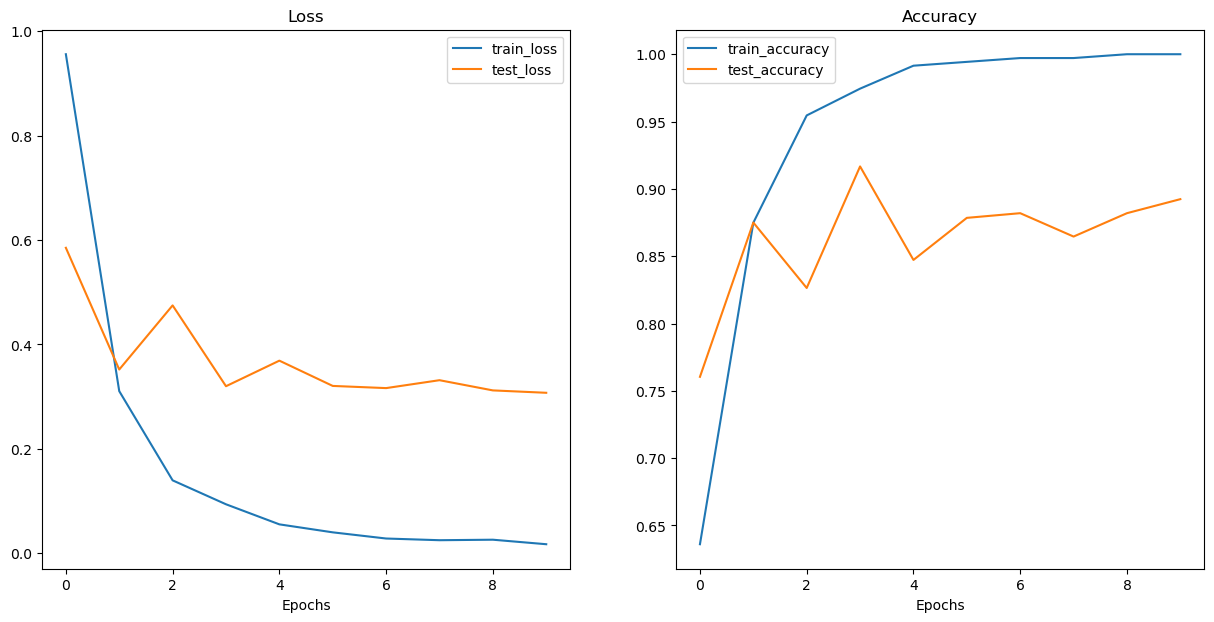

In [282]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_model_results)

#### Saving our best model

In [285]:
from going_modular import utils

utils.save_model(model = vit_pretrained,
                target_dir= "/Users/venu/Documents/Productivity/Pytorch Tutorials/Models",
                model_name = "Pre-Trained Model ViT Feature Extractor DBZ Character Classifier.pth")

[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/Pre-Trained Model ViT Feature Extractor DBZ Character Classifier.pth


##### Our model is close to 343.3 MB

### 11. Predicting on Custom Image Data

In [286]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# 1. create a function to take in the model and other required args
def predict_and_plot_image(model: torch.nn.Module,
                          class_names: List[str],
                          image_path: str,
                          transform: torchvision.transforms = None,
                          image_size: Tuple[int, int] = (224, 224),
                           device: torch.device = "cpu"
):
    #2. open the image using PIL
    target_image = Image.open(image_path)

    #3. create a transform for the target image
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([transforms.Resize(image_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]
                                            )

    #4. Make sure the model is on the target device
    model.to(device)

    ### Prediction on the target Image

    #5. Put the model in eval mode 
    model.eval()
    with torch.inference_mode():
        #6. Transform the target image and add an extra dimension for batch size ->[B,c,H,W]
        transformed_image = image_transform(target_image).unsqueeze(dim = 0)

        #7. Make prediction on the transformed image and also ensuring its on the target device
        pred_logits = model(transformed_image).to(device)

    #8. Converting the logits into prediction probs
    pred_probs = torch.softmax(pred_logits, dim = 1)

    #9. Converitng the prediction probs into prediction labels
    pred_label = torch.argmax(pred_probs, dim = 1)

    #10. Plot the target image by titling the label with the predicted class name
    plt.figure()
    plt.imshow(target_image)
    plt.title(f"Predicted Class: {class_names[pred_label]},  with Probability {pred_probs.max():.3f}")
    plt.axis(False);
    

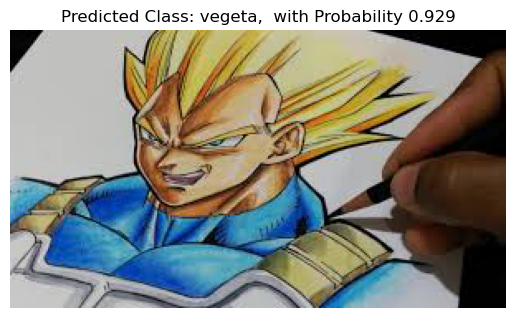

In [291]:
## Download Custom Images

# Setup custom image path
custom_image_path = "/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images_20percent/test/vegeta/download (14).jpeg"

# predict on custom image
predict_and_plot_image(model = vit_pretrained,
                      image_path= custom_image_path,
                      class_names = class_names)